##**Solution of Burgers' Equation using PINNS**

$$
u_{t}+ uu_{x}-(0.01/\pi)u_{xx}=0, ~~~x~\epsilon~~[-1,1],
~~t~\epsilon[0,1]
$$
$$
u(0,x)=-sin(\pi x)
$$
$$
u(t,-1)=u(t,1)=0
$$

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc

In [ ]:
tf.keras.backend.set_floatx('float64')


In [ ]:
### generating data

# number of boundary and initial data points
# Nd = number_of_ic_points + number_of_bc1_points + number_of_bc1_points
number_of_ic_points = 50
number_of_bc1_points = 25
number_of_bc2_points = 25

# Latin Hypercube Sampling (LHS) engine ; to sample random points in domain,
engine = qmc.LatinHypercube(d=1)

# temporal data points
t_d = engine.random(n=number_of_bc1_points + number_of_bc2_points)
temp = np.zeros([number_of_ic_points, 1]) # for initial condition t=0
t_d = np.append(temp, t_d, axis=0)        # for boundary condition


# spatial data points
x_d = engine.random(n=number_of_ic_points)
x_d = 2 * (x_d - 0.5)                    #scales the values from [0,1] to [-1,1]
temp1 = -1 * np.ones([number_of_bc1_points, 1]) # for BC1 ; x = -1
temp2 = +1 * np.ones([number_of_bc2_points, 1]) # for BC2 ; x = +1
x_d = np.append(x_d, temp1, axis=0)
x_d = np.append(x_d, temp2, axis=0)             # total 100 points

x_d.shape, t_d.shape

((100, 1), (100, 1))

Text(0.5, 1.0, 'Data points')

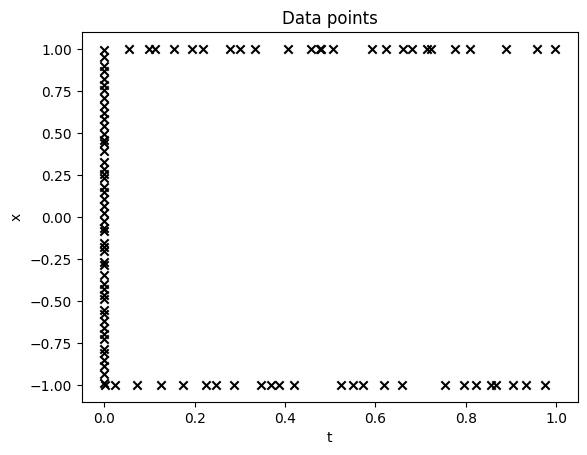

In [ ]:
# view randomly sampled boundary and initial points
plt.scatter(t_d, x_d, marker="x", c="k")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Data points")

In [ ]:
# initizalize an array for the output of boundary and initial conditions
y_d = np.zeros(x_d.shape)

# update it according to the initial condition
y_d[ : number_of_ic_points] = -np.sin(np.pi * x_d[:number_of_ic_points])

# all boundary conditions are also set to zero
y_d[number_of_ic_points : number_of_bc1_points + number_of_ic_points] = 0
y_d[number_of_bc1_points + number_of_ic_points : number_of_bc1_points + number_of_ic_points + number_of_bc2_points] = 0

In [ ]:
# number of collocation points for the physics loss function
Nc = 10000

# LHS for collocation points
engine = qmc.LatinHypercube(d=2)
points = engine.random(n=Nc)
# set x values between -1. and +1. We will assign this to x in next step
points[:, 1] = 2*(points[:, 1]-0.5)

# change names for easier identification
t_c = np.expand_dims(points[:, 0], axis=1)
x_c = np.expand_dims(points[:, 1], axis=1)

print(t_c[:3])
print(t_c.shape)

[[0.15481472]
 [0.31540995]
 [0.41536643]]
(10000, 1)


In [ ]:
# convert all data and collocation points to tf.Tensor
x_d, t_d, y_d, x_c, t_c = map(tf.convert_to_tensor, [x_d, t_d, y_d, x_c, t_c])

In [ ]:
### model design
neuron_per_layer = 20
# activation function for all hidden layers
actfn = "tanh"

# input layer
input_layer = tf.keras.layers.Input(shape=(2,))

num_hidden_layers = 8

# Start with the input layer
hidden = input_layer

# Create hidden layers using a loop
for i in range(num_hidden_layers):
    hidden = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden)

# output layer
output_layer = tf.keras.layers.Dense(1, activation=None)(hidden)

model = tf.keras.Model(input_layer, output_layer)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,021 (23.60 KB)

 Trainable params: 3,021 (23.60 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
@tf.function
def u(t, x):
    u = model(tf.concat([t, x], axis=1))
    return u

$$F=u_{t}+ uu_{x}-(0.01/\pi)u_{xx}$$

In [ ]:
# the physics informed loss function
# this loss function is used for collocation points
@tf.function
def F(t, x):
    u0 = u(t, x)
    u_t = tf.gradients(u0, t)[0]
    u_x = tf.gradients(u0, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    F = u_t + u0*u_x - (0.01/np.pi)*u_xx
    return tf.reduce_mean(tf.square(F))

In [ ]:
# this loss function is used for data points we randomly generated
@tf.function
def mse(y, y_pred):
    return tf.reduce_mean(tf.square(y-y_pred))

In [ ]:


epochs = 15000
loss_list = []

opt = tf.keras.optimizers.Adam(learning_rate=5e-4)

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # model output/prediction
        y_pred = u(t_d, x_d)
        # physics-informed loss for collocation points
        L1 = F(t_c, x_c)
        # MSE loss for data points
        L2 = mse(y_d, y_pred)
        loss = L1 + L2
    # compute gradients
    g = tape.gradient(loss, model.trainable_weights)
    loss_list.append(loss)
    # apply gradients
    opt.apply_gradients(zip(g, model.trainable_weights))


Text(0.5, 0, 'epoch')

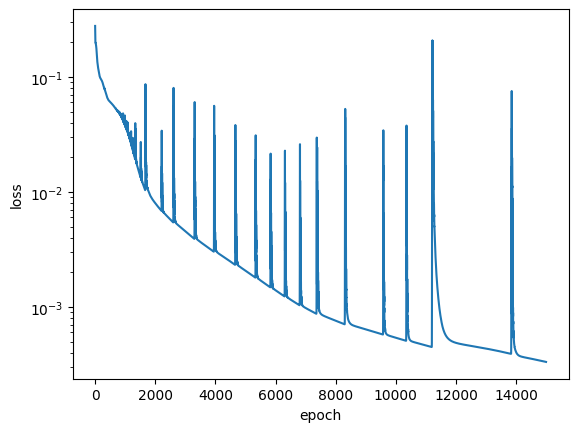

In [ ]:
plt.semilogy(range(epochs), loss_list)
#This function creates a plot with a logarithmic scale on the y-axis
plt.ylabel("loss")
plt.xlabel("epoch")

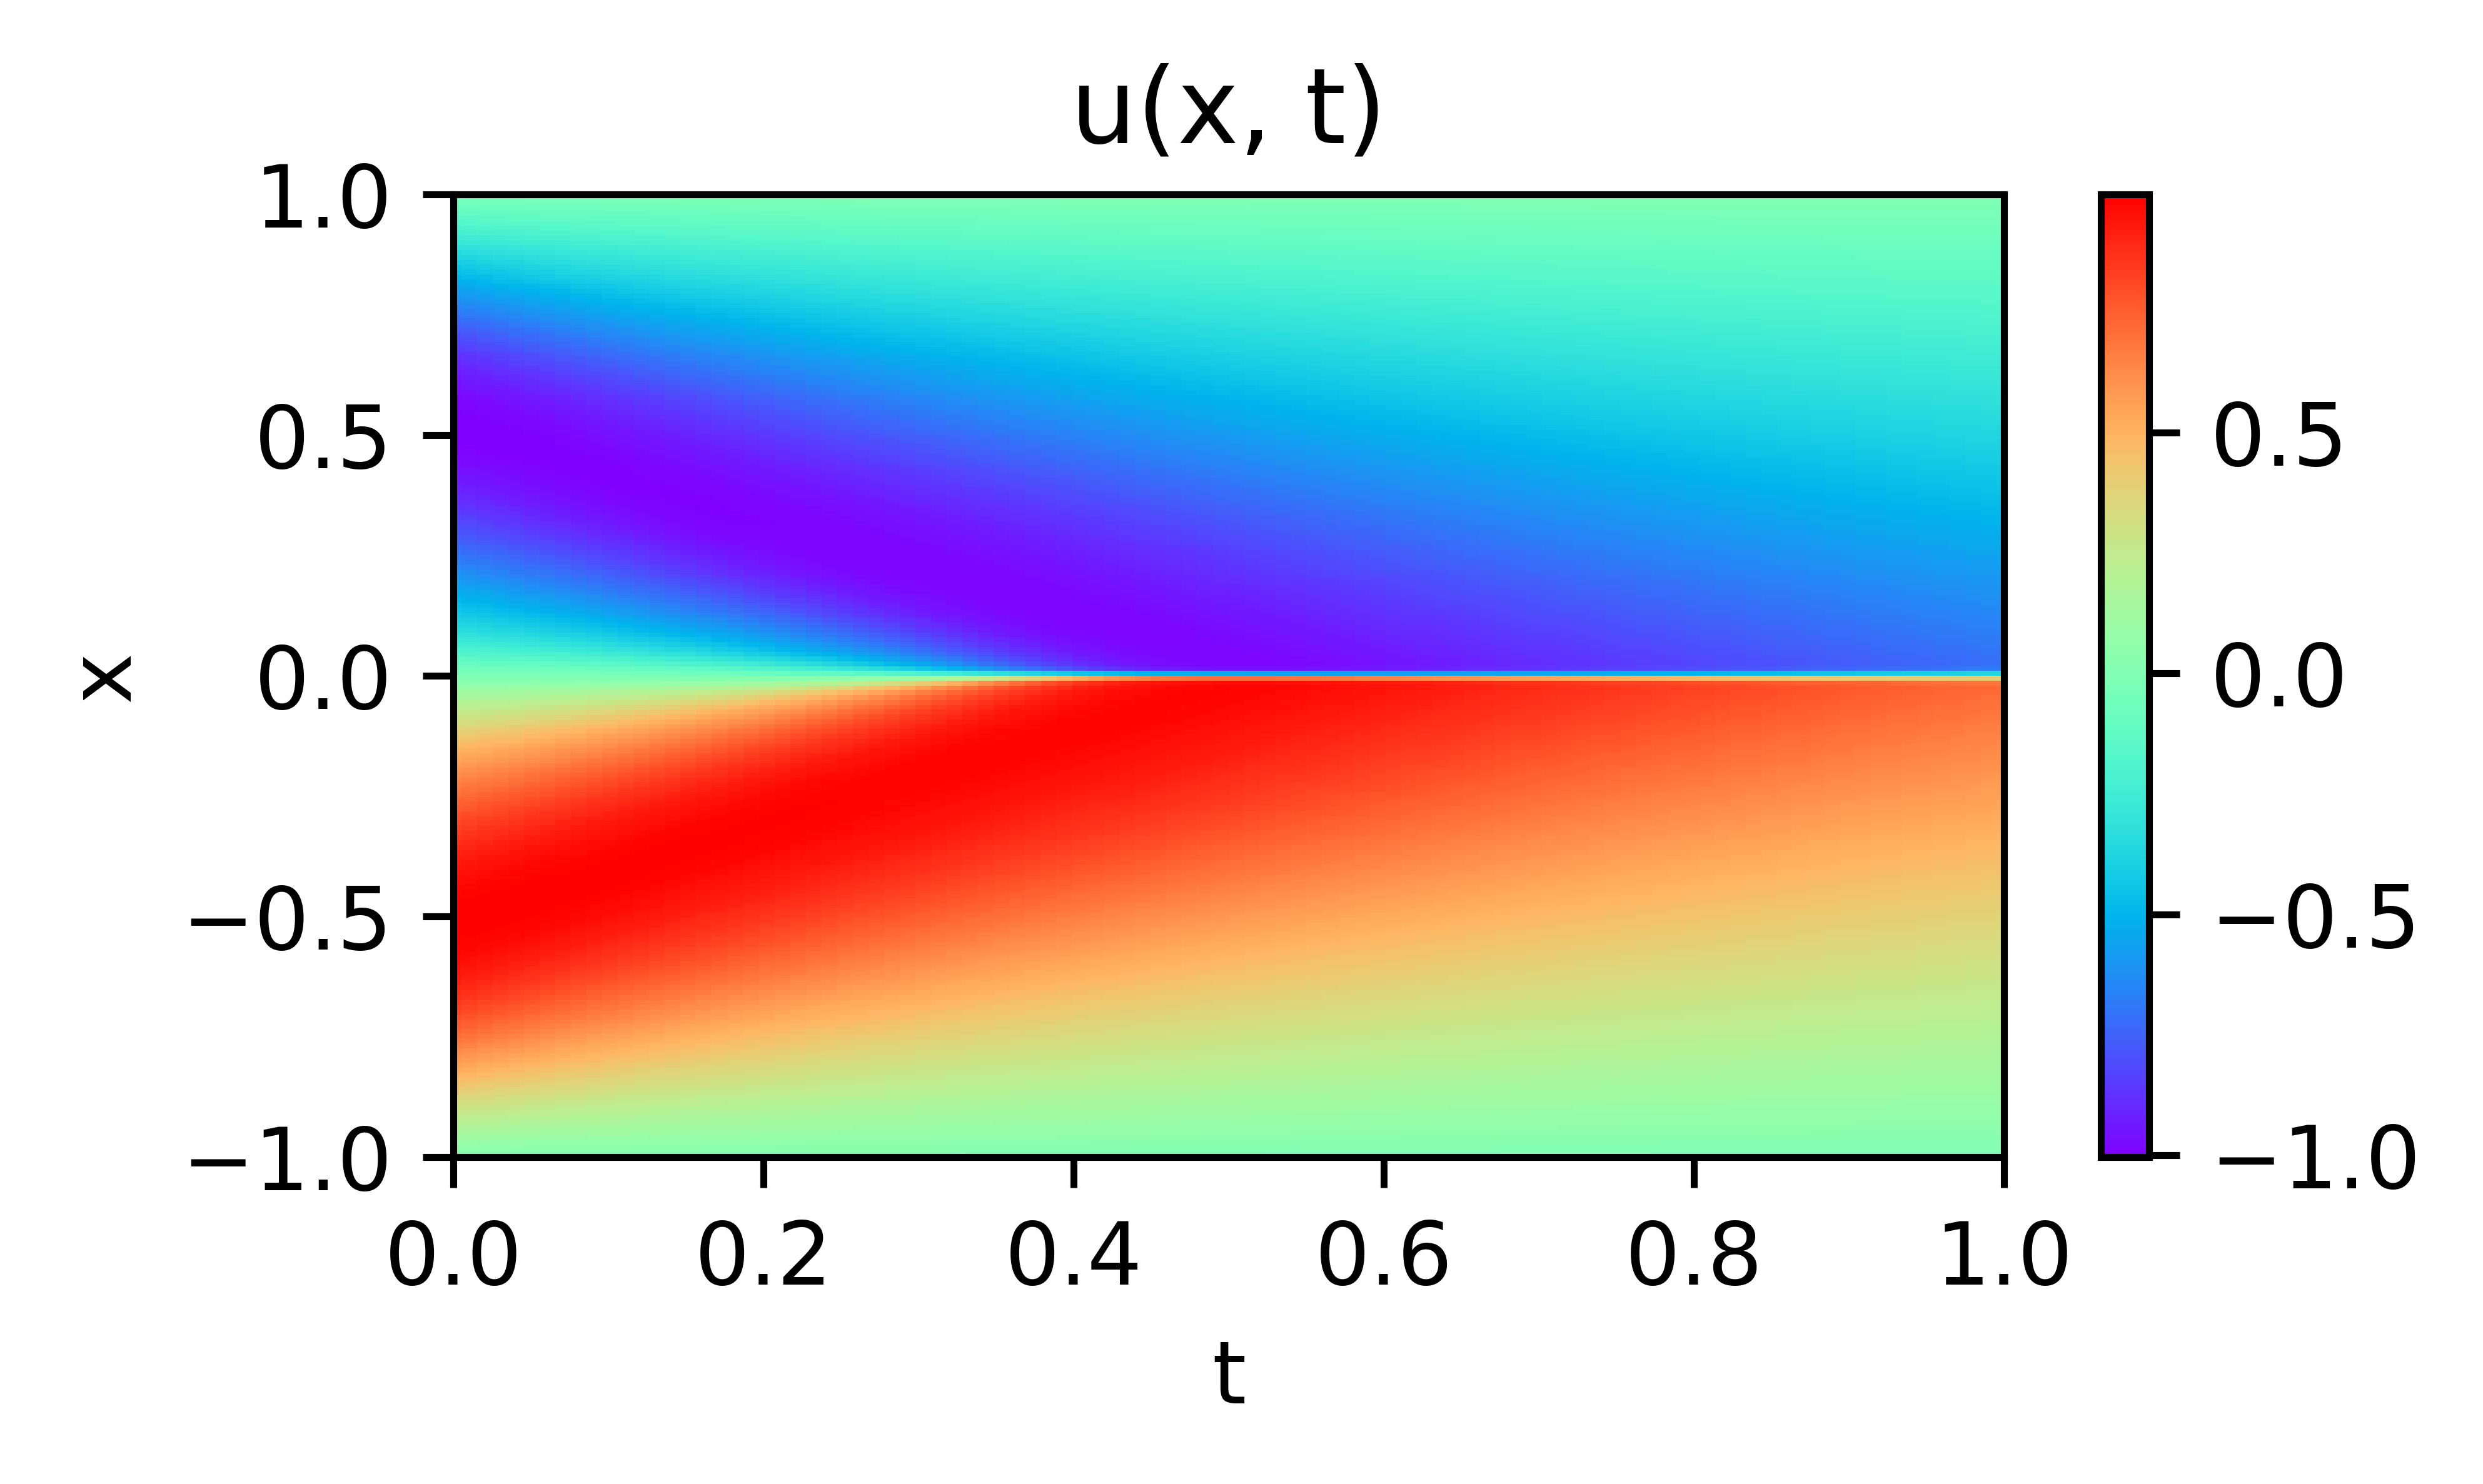

In [ ]:
### plot
n, m = 100, 200
X = np.linspace(-1, +1, m)
T = np.linspace(0, 1, n)
X0, T0 = np.meshgrid(X, T)
#tensor flow expects 2D array
X = X0.reshape([n*m, 1])
T = T0.reshape([n*m, 1])


X = tf.convert_to_tensor(X)
T = tf.convert_to_tensor(T)
X.shape, T.shape
plt.figure(figsize=(4, 2), dpi=1000)
S = u(T, X)
S = S.numpy().reshape(n, m)


plt.pcolormesh(T0, X0, S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(-1, +1)
plt.title("u(x, t)")
plt.ylabel("x")
plt.xlabel("t")
#plt.scatter(t_d, x_d, marker="x", c="k")
plt.show()